# Quick Start Pymrio Tutorial using WIOD

This notebook contains the interactive version of the quick start given in the Pymrio article [(Stadler et al 2018 sub)](https://github.com/konstantinstadler/pymrio_article).

Pymrio requires a Python version >= 3.7. If you don't have Python installed, I recommend to use the [Anaconda Scientific Python package](https://www.anaconda.com/download).

Pymrio is available on 

<a href=https://badge.fury.io/py/pymrio>
<img src="https://badge.fury.io/py/pymrio.svg" alt="the Python Package Index PyPI" align=left>
</a>
<br>


and on

<a href="https://anaconda.org/conda-forge/pymrio"> <img src="https://anaconda.org/conda-forge/pymrio/badges/version.svg" /> </a>
<br>

Thus, two possibilities exist to install Pymrio and all required packages. 

For using the version on PyPI use:

```
pip install pymrio --upgrade
```

To install from the Anaconda Cloud do:

```
conda install -c conda-forge pymrio
```

Further down in that notebood we will also use the [country_converter](https://github.com/konstantinstadler/country_converter) package as well as [seaborn](https://seaborn.pydata.org/) and [matplotlib](https://matplotlib.org/) for some plotting. You can install these packages with pip or conda analog to pymrio. Alternatively, you can also run this notebook in the cloud via binder following this link:

[![badge](https://img.shields.io/badge/launch-binder-579ACA.svg?logo=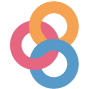)](https://mybinder.org/v2/gh/konstantinstadler/pymrio_article/master?filepath=%2Fnotebook%2Fpymrio-tutorial-for-wiod.ipynb)


You can than import the Pymrio package with

In [2]:
import pymrio

In this example here, we will use the [WIOD MRIO database](http://www.wiod.org/home).

First, the Pymrio MRIO download function is used to get the WIOD MRIO database with:

In [3]:
raw_wiod_path = '/tmp/wiod/raw'
pymrio.download_wiod2013(storage_folder=raw_wiod_path,
                         years=[2008])

Description: WIOD metadata file for pymrio
MRIO Name: WIOD
System: IxI
Version: data13
File: /tmp/wiod/raw/metadata.json
History:
20210715 11:01:53 - FILEIO -  Downloaded http://www.wiod.org/protected3/data13/water/wat_may12.zip to wat_may12.zip
20210715 11:01:52 - FILEIO -  Downloaded http://www.wiod.org/protected3/data13/materials/mat_may12.zip to mat_may12.zip
20210715 11:01:52 - FILEIO -  Downloaded http://www.wiod.org/protected3/data13/land/lan_may12.zip to lan_may12.zip
20210715 11:01:52 - FILEIO -  Downloaded http://www.wiod.org/protected3/data13/AIR/AIR_may12.zip to AIR_may12.zip
20210715 11:01:51 - FILEIO -  Downloaded http://www.wiod.org/protected3/data13/CO2/CO2_may12.zip to CO2_may12.zip
20210715 11:01:51 - FILEIO -  Downloaded http://www.wiod.org/protected3/data13/EM/EM_may12.zip to EM_may12.zip
20210715 11:01:51 - FILEIO -  Downloaded http://www.wiod.org/protected3/data13/EU/EU_may12.zip to EU_may12.zip
20210715 11:01:50 - FILEIO -  Downloaded http://www.wiod.org/protecte

This downloads the 2008 MRIO table from WIOD. Omitting the year parameter would result getting all years.
The function returns a Pymrio meta data object, which gives information about the WIOD version, system (in this case industry by industry) and records about from where the data was received.

To parse the database into a Pymrio object use:

In [4]:
wiod = pymrio.parse_wiod(raw_wiod_path, year=2008)

The available data can be explored by for example:

In [5]:
wiod.get_sectors()

Index(['AtB', 'C', '15t16', '17t18', '19', '20', '21t22', '23', '24', '25',
       '26', '27t28', '29', '30t33', '34t35', '36t37', 'E', 'F', '50', '51',
       '52', 'H', '60', '61', '62', '63', '64', 'J', '70', '71t74', 'L', 'M',
       'N', 'O', 'P'],
      dtype='object', name='sector')

or

In [ ]:
wiod.get_regions()

In [ ]:
wiod.Z

WIOD includes several satellite accounts, which are stored as child objects in Pymrio. 
For example, in order to see the AIR emissions provided by WIOD:



In [ ]:
wiod.AIR.F


WIOD, however, does neither provide any normalized data (A-matrix, satellite account coefficient data) nor any consumption based accounts (footprints).

In order to calculate them, one could go through all the missing data and compute each account. 
Pymrio provides the required function, for example to calculate the A-matrix:


In [ ]:
x = pymrio.calc_x(Z=wiod.Z, Y=wiod.Y)
A = pymrio.calc_A(Z=wiod.Z, x=x)

In [ ]:
A.head()

Alternatively, Pymrio provides a function which iterates through all missing accounts and calculates them:

In [ ]:
wiod.calc_all()

At this point, a basic EE MRIO analysis is accomplished. For example, the regional consumption based accounts of the AIR emissions are now given by:

In [ ]:
wiod.AIR.D_cba_reg

In [ ]:
wiod.AIR.unit

Pymrio can be linked with the [country converter coco](http://joss.theoj.org/papers/af694f2e5994b8aacbad119c4005e113) to ease the aggregation of MRIO and results into different classifications.
Using the country converter, WIOD can be aggregated into EU and non-EU countries with singling out Germany by:

In [ ]:
import country_converter as coco
wiod.aggregate(region_agg = coco.agg_conc(original_countries='WIOD',
                                          aggregates=[{'DEU': 'DEU', 'GBR':'GBR'}, 'EU'],
                                          missing_countries='Other',
                                          merge_multiple_string=None))


We rename the EU account to reflect that is does not include Germany:

In [ ]:
wiod.rename_regions({'EU':'Rest of EU'})

The regional footprint account are now:

In [ ]:
wiod.AIR.D_cba_reg

To visualize for example the CH4 accounts:

In [ ]:
import matplotlib.pyplot as plt
with plt.style.context('ggplot'):
    wiod.AIR.plot_account('CH4', figsize=(8,5))
    plt.savefig('/tmp/wiod/airch4.png', dpi=300)
    plt.show()

To calculate the source (in terms of regions and sectors) of a certain stressor or impact driven by consumption, one needs to diagonalize this stressor/impact. This can be done with Pymrio by:

In [ ]:
diag_CH4 = wiod.AIR.diag_stressor('CH4')

and be reassigned to the aggregated WIOD system:

In [ ]:
wiod.CH4_source = diag_CH4

In the next step the automatic calculation routine of Pymrio is called again to compute the missing accounts in this new extension:
and be reassigned to the aggregated WIOD system:

In [ ]:
wiod.calc_all()

The diagonalized CH4 data now shows the source and destination of the specified stressor (CH4):

In [ ]:
wiod.CH4_source.D_cba.head()

In this square footprint matrix, every column represents the amount of stressor occurring in each region - sector driven by the consumption stated in the column header. Conversly, each row states where the stressor impacts occurring in the row are distributed due (from where they are driven).

In [ ]:
CH4_source_reg = wiod.CH4_source.D_cba.groupby(
    level='region', axis=0).sum().groupby(
    level='region', axis=1).sum()


In [ ]:
CH4_source_reg

In [ ]:
import seaborn as sns
CH4_source_reg.columns.name = 'Receiving region'
CH4_source_reg.index.name = 'Souce region'
sns.heatmap(CH4_source_reg, vmax=5E6, 
            annot=True, cmap='YlOrRd', linewidths=0.1,
            cbar_kws={'label': 'CH4 emissions ({})'.format(wiod.CH4_source.unit.unit[0])})
plt.savefig('/tmp/wiod/airch4_source_reg.png', dpi=300)
plt.show()

Storing the MRIO database can be done with 

In [ ]:
storage_path = '/tmp/wiod/aly'
wiod.save_all(storage_path)

From where it can be received subsequently by:

In [ ]:
wiod = pymrio.load_all(storage_path)

The meta attribute of Pymrio mentioned at the beginning kept track of all modifications of the system.
This can be shown with:

In [ ]:
wiod.meta

Custom notes can be added to the meta with:

In [ ]:
wiod.meta.note("Custom note")

The history of the meta data can be filtered for specific entries like:

In [ ]:
wiod.meta.file_io_history

This tutorial gave a short overview about the basic functionality of Pymrio. For more information about the capabilities of pymrio check the [online documentation](http://pymrio.readthedocs.io/en/latest/index.html).

<a href=https://creativecommons.org/licenses/by/4.0/>
<img src="https://img.shields.io/badge/License-CC%20BY%204.0-lightgrey.svg" alt="CC-BY4.0 licence" align=right>
</img>
</a>
<br>
<div style="text-align: right"> Licences of underlying dataset and software apply. </div>